# **CIS 520: Machine Learning, Fall 2020**
# **Week 5, Worksheet 4**
## **Generative Adversarial Networks (GANs)**


- **Content Creators:** Michael Zhou
- **Content Reviewers:** Siyun Hu, Shaozhe Lyu
- **Acknowledgements:** This notebook contains an excerpt from [Generative Adversarial Networks Using Pytorch](https://medium.com/@attyuttam/generative-adversarial-networks-using-pytorch-3ad31cc61ac8) by Attyuttam Saha.



The objective of this notebook is to provide a brief introduction to the concept of generative adversarial networks (GANs). We will describe the mechanics of such networks and explore its use with the Fashion MNIST dataset so that you can develop your own simple GAN.

Generative adversarial networks (GANs) are a powerful and flexible class of unsupervised learning algorithms used for generative modeling.
Generative modeling is an unsupervised learning task that involves discovering and learning patterns in input data such that the model can generate or output new examples that could have hypothetically been drawn from the original dataset.

In this section, we will develop the intuition behind generative adversarial networks and their use in image reconstruction problems.

We begin with the standard imports:

In [ ]:
%matplotlib inline
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
import matplotlib.pyplot as plt

## Mechanics of Generative Adversarial Networks

A simple GAN consists of two different types of models: a generator model and a discriminator model. The generator model's purpose is to generate new examples from random input vectors given to it. The discriminator model is a simple classifier that takes as input an image and designates it as either a Real or Fake image. In the context of GANs, a Fake image is an image created by the generator while a Real image is an image provided from the dataset. The fundamental concept of GANs revolves around the generator being able to fool the discriminator.

The adversarial aspect of GANs comes from the fact that while the generator creates sets of images and feeds them to the discriminator, the discriminator becomes well trained in understanding what real images are as it is being trained with inputs from the dataset. If the generator is successful in making the discriminator believe that its generated images are real, then the generator is considered successful. Both models are trying to oppose each other, with the generator trying to fool the discriminator while the discriminator tries to avoid being fooled.

To illustrate these concepts, let us start by considering the Fashion MNIST dataset, a dataset with images of different clothing accessories:

In [ ]:
from torchvision.datasets import FashionMNIST

# Load the Fashion MNIST dataset

mnist = FashionMNIST(root='data', train=True, download=True,
                     transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)




We can now visualize one on the images in this dataset as follows:


Label: 9


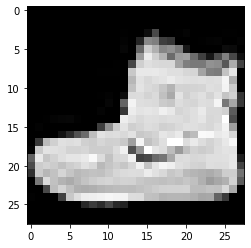

In [ ]:
# When viewing images we would like to de normalize them 
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# Visualizing the data
img, label = mnist[0]
img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

## Setup of Model Dataloader

During the training of our GAN, we would want the data to be loaded in batches. Doing so would allow training to be performed on an individual batch before the weights are updated. To achieve this, we can make use of the data loader provided by PyTorch.

In [ ]:
from torch.utils.data import DataLoader

# Ensures that data is loaded in batches during training phase
batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

To ensure that the batches are being properly packaged, we can view the labels of all images from the first batch and one of its images:

First Batch
torch.Size([100, 1, 28, 28])
tensor([0, 5, 6, 7, 7, 3, 8, 3, 5, 6, 8, 6, 0, 3, 6, 9, 2, 1, 8, 3, 4, 1, 1, 8,
        7, 2, 1, 5, 8, 9, 7, 6, 8, 7, 0, 2, 9, 9, 0, 1, 8, 6, 3, 3, 7, 0, 6, 8,
        9, 1, 7, 3, 1, 1, 4, 7, 4, 0, 7, 1, 3, 8, 2, 3, 5, 5, 9, 8, 8, 5, 5, 7,
        1, 9, 3, 6, 1, 4, 5, 2, 4, 0, 8, 5, 8, 1, 2, 6, 5, 4, 9, 0, 1, 2, 2, 1,
        8, 1, 8, 2])


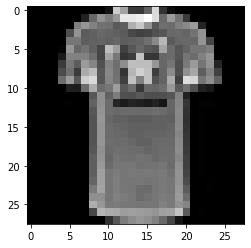

In [ ]:
# Print all the images in a batch
for img_batch, label_batch in data_loader:
    print('First Batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

Now that we have set up the dataloader, we can move onto defining the components of our GAN architecture.

## Generative Adversarial Networks: Model Definitions



### Discriminator Model Setup

As previously mentioned, the discriminator is a simple classifier that is tasked with distinguishing between fake and real images. Even though we can definitely use a CNN model for better classification, we will use a simple feed forward neural network for this example given the relative simplicity of the Fashion MNIST dataset. Of course, you are free to use a CNN for much better results.

In [ ]:
import torch.nn as nn

image_size = 784
hidden_size = 256

# Define a simple Disriminator network
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

Here, we have defined our discriminator as having the following flow and architecture:


1.   Linear layer takes in an image input of size 784 and hidden size of 256
2.   Output of the linear layer is passed through a Leaky ReLU activation function
3.   Result of the activation function is passed through a linear layer that takes in input of size 256 and produces 256 outputs
4.   Results of second linear layer are passed through another Leaky ReLU activation function
5.   Result of second activation function is passed through another linear layer, after which it is passed through the sigmoid function





### Generator Model Setup

We will now move onto the setup of the generator model. The input to the generator is a random input vector known as the latent variable, or a latent space. In the context of GANs, the generator applies meaning to points in a chosen latest space such that new points drawn from the latest space can be provided to the generator as input and used to generate new and different output examples.

In [ ]:
latent_size = 64

# Define a simple Generator network
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

Here, we have defined our generator as having the following flow and architecture:


1.   Linear layer takes in an image input of size 64 and hidden size of 256
2.   Output of the linear layer is passed through a ReLU activation function
3.   Result of the activation function is passed through a linear layer that takes in input of size 256 and produces 256 outputs
4.   Results of second linear layer are passed through another ReLU activation function
5.   Result of second activation function is passed through another linear layer, after which it is passed through the tanh() function

To get a sense for the types of outputs we can expect from a generator before training, we will visualize some test images:

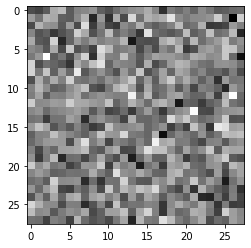

In [ ]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())
plt.imshow(gen_imgs[0], cmap='gray')
plt.imshow(gen_imgs[1], cmap='gray')

As one might expect, these early sample images are not great in terms of quality. Certainly they will not be fooling anyone. In order to improve these images, we will need to train our generator and discriminator networks.

## Training the GAN Model Networks



### Training the Discriminator

Given that the discriminator is a binary classifier, we will be using the binary cross entropy loss function to measure the performance of the discriminator in classification. We will also use the Adam optimizer to perform gradient descent.

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

# Training the discriminator
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

Training for the discriminator takes place in two major phases. First, we use the given set of real images and feed them to the discriminator to train it to understand the pattern of the real images. Second, we generate a set of fake images and feed them to the discriminator to train it to understand the pattern of the fake images.

To do this, we find the loss both the real and fake images, setting the labels of the loss function to 1 for the real images and to 0 for the fake images. After we calculate the loss for both the real and fake images, we add the two losses as the net loss for the discriminator.

### Training the Generator

Since the generator produces images, training is a bit more difficult. However, we can make the process easier by including the discriminator as part of the loss function. First, we will generate a batch of images from the generator. Then, we will pass these images to the discriminator and set the labels to 1 to try fooling the discriminator into treating these generated images as real. This will indicate how far the images of the generator are from actual real images. We will then use the loss to update the weights of the generator.

In [ ]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

### Training the Model Architecture

Finally, it is time to put together the components of our GAN and train on the entire model architecture. We will start by creating a directory to save intermediate results from the generator during training:

In [ ]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Next, we will create a helper function to save the generated images into this directory:

Saving fake_images-0000.png


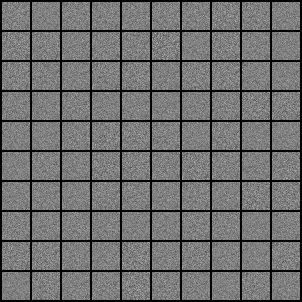

In [ ]:
from IPython.display import Image
from torchvision.utils import save_image

sample_vectors = torch.randn(batch_size, latent_size)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

With this preliminary setup complete, we can begin the main training phase of our model architecture:

**Note:** Training for GANs can be very time-consuming, so you can expect the cell below to take about 30 minutes to execute.

In [ ]:
%%time
num_epochs = 75
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch {}, Step {}, D_Loss: {:.4f}, G_Loss: {:.4f}, Real Accuracy: {:.2f}, Fake Accuracy: {:.2f}' 
                  .format(epoch, i+1, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch 0, Step 200, D_Loss: 0.0949, G_Loss: 3.8693, Real Accuracy: 0.97, Fake Accuracy: 0.06
Epoch 0, Step 400, D_Loss: 0.0742, G_Loss: 5.4931, Real Accuracy: 0.99, Fake Accuracy: 0.06
Epoch 0, Step 600, D_Loss: 0.0226, G_Loss: 5.2774, Real Accuracy: 0.99, Fake Accuracy: 0.01
Saving fake_images-0001.png
Epoch 1, Step 200, D_Loss: 0.0255, G_Loss: 5.0919, Real Accuracy: 0.99, Fake Accuracy: 0.02
Epoch 1, Step 400, D_Loss: 0.0107, G_Loss: 5.2966, Real Accuracy: 1.00, Fake Accuracy: 0.01
Epoch 1, Step 600, D_Loss: 0.0265, G_Loss: 6.5789, Real Accuracy: 0.99, Fake Accuracy: 0.01
Saving fake_images-0002.png
Epoch 2, Step 200, D_Loss: 0.0163, G_Loss: 5.9464, Real Accuracy: 0.99, Fake Accuracy: 0.01
Epoch 2, Step 400, D_Loss: 0.1097, G_Loss: 7.3060, Real Accuracy: 0.96, Fake Accuracy: 0.02
Epoch 2, Step 600, D_Loss: 0.0179, G_Loss: 6.8992, Real Accuracy: 1.00, Fake Accuracy: 0.02
Saving fake_images-0003.png
Epoch 3, Step 200, D_Loss: 0.1534, G_Loss: 6.0320, Real Accuracy: 0.96, Fake Accuracy: 0

## Viewing GAN Results and Metrics

With training of our simple GAN complete, we can look at some of the intermediate results to better visualize the training process:

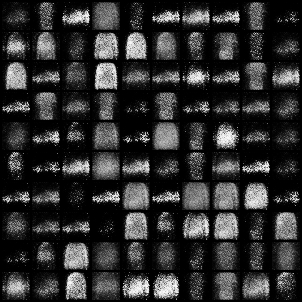

In [ ]:
Image('./samples/fake_images-0010.png')

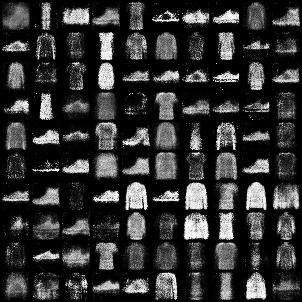

In [ ]:
Image('./samples/fake_images-0050.png')

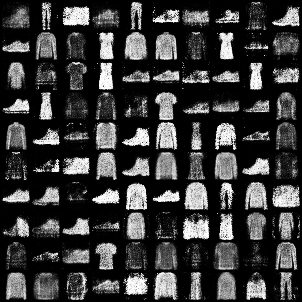

In [ ]:
Image('./samples/fake_images-0100.png')

As we can observe, our results for the generated images do improve steadily over time, illustrating the effects of our training.

We can also view the losses and accuracies for the generator and the discriminator of our GAN for further analysis. Our main aim is to ensure that the loss of the generator reduces over time given that the loss of the discriminator does not become too high.

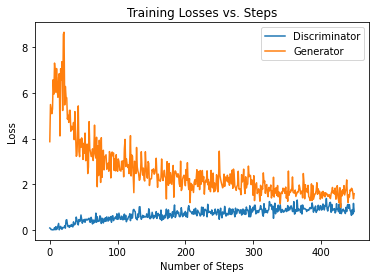

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('Number of Steps')
plt.ylabel('Loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Training Losses vs. Steps');

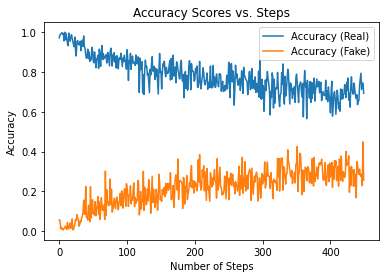

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('Number of Steps')
plt.ylabel('Accuracy')
plt.legend(['Accuracy (Real)', 'Accuracy (Fake)'])
plt.title('Accuracy Scores vs. Steps');

## Exercises

To enhance your understanding and learning experience, consider the following questions and exercises:

*   What trends do you observe for the losses of the discriminator and generator? Can you explain these trends?
*   Change the number of epochs and the learning rate of the optimizer. What happens to the performance of the GAN, and why?
*   Observe what happens when you try to change other aspects of the model architecture or training setup. Which modifications cause the model to perform better? Which ones cause the model to perform worse?

